<a href="https://colab.research.google.com/github/Zainabshk06/Python/blob/main/Etherium_XGboost_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Time Series Forecasting for Ethereum Historical Prices

# 1. Title
Time Series Forecasting of Ethereum Prices Using XGBoost

# 2. Problem Statement
The goal of this project is to analyze historical Ethereum prices, perform exploratory data analysis (EDA), and develop a forecasting model to predict future Ethereum prices. Accurate price predictions can help investors make informed decisions in cryptocurrency trading and market analysis.

# 3. Data Overview
Dataset: Ethereum Historical Data (2018 - 2024) from Kaggle
Features:

1. time: Date of the recorded price
2. Open: Opening price of Ethereum on the day
3. High: Highest price of Ethereum on the day
4. Low: Lowest price of Ethereum on the day
5. Close: Closing price of Ethereum on the day
6. Volume: Trading volume of Ethereum on the day

Link to Dataset:
https://www.kaggle.com/datasets/heidarmirhajisadati/ethereum-historical-data-2018-2024/data

# 4. Extracting Data Using Kaggle API
To extract data from Kaggle using its API, follow these steps:



In [29]:
# # Install the Kaggle package
# !pip install kaggle

# # Upload Kaggle API token (Make sure to download your kaggle.json from your Kaggle account)
# from google.colab import files
# files.upload()

# # Create a kaggle directory and move the API token to the correct directory
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# # Download the dataset
# !kaggle datasets download -d heidarmirhajisadati/ethereum-historical-data-2018-2024

# # Unzip the dataset
# !unzip ethereum-historical-data-2018-2024.zip

# 5. Data Loading and Overview

In [30]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/ethereum_daily_data_2018_2024.csv')

# Display the first few rows
df.head()

,time,Open,High,Low,Close,Volume
0,2018-01-01,741.69,766.49,718.90,757.22,910875.63
1,2018-01-02,756.17,882.61,756.17,861.97,1123318.86
2,2018-01-03,861.97,951.70,847.90,941.10,871172.13
3,2018-01-04,941.00,997.44,901.03,944.83,822844.78
4,2018-01-05,944.50,1165.81,926.75,963.88,1682729.53


# 6. Data Cleaning
To clean the dataset, we follow these steps:

## 1. Check for Missing Values:

In [31]:
df.isnull().sum()  # No missing values found in this dataset


,0
time,0
Open,0
High,0
Low,0
Close,0
Volume,0


## 2. Check for Duplicates:

In [32]:
df.duplicated().sum()  # Check if there are any duplicate rows

1

In [33]:
df.drop_duplicates(inplace=True)  # Drop duplicates if necessary


## 3. Ensure Correct Data Types:
Ensure that the time column is of the datetime type and all other columns are numeric:

In [34]:
df.dtypes  # Check data types


,0
time,object
Open,float64
High,float64
Low,float64
Close,float64
Volume,float64


In [35]:
df['time'] = pd.to_datetime(df['time'])  # Ensure time is a datetime object
print(df.dtypes)

time      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume           float64
dtype: object


## 4. Check for Outliers: Use a boxplot to check for outliers in the Volume column and handle them:

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future ve

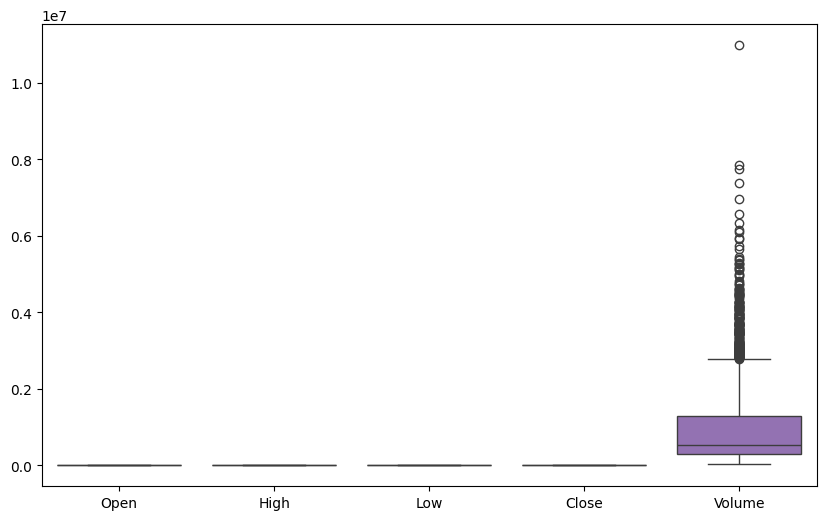

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(data=df)
plt.show()

In [37]:
# Calculate Q1 and Q3 for the entire DataFrame
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)

# Calculate IQR for all columns
IQR = Q3 - Q1

# Identify outliers across all columns
outliers = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))

# Count the number of outliers in each column
outlier_counts_per_column = outliers.sum()

# Count the total number of outlier values
total_outlier_count = outliers.sum().sum()

print(f'Number of outliers in each column:\n{outlier_counts_per_column}')
print(f'Total number of outlier values: {total_outlier_count}')


Number of outliers in each column:
time        0
Open        0
High        0
Low         0
Close       0
Volume    207
dtype: int64
Total number of outlier values: 207


In [38]:
# Cap values in 'Volume' at the 99th percentile
threshold = df['Volume'].quantile(0.99)
df['Volume'] = df['Volume'].clip(upper=threshold)

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


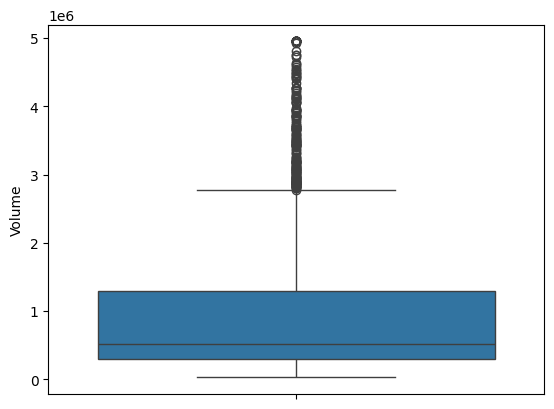

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(y=df['Volume'])
plt.show()


## 5. Handle Incorrect or Inconsistent Data

In [40]:
# Check for zero or negative values in price-related columns
zero_or_negative_prices = df[(df['Open'] <= 0) | (df['High'] <= 0) | (df['Low'] <= 0) | (df['Close'] <= 0)]

print(f"Number of rows with zero or negative prices: {zero_or_negative_prices.shape[0]}")


Number of rows with zero or negative prices: 0


## 6. Normalize Date Range

In [41]:
# Step 1: Set 'time' as the index
df.set_index('time', inplace=True)
df

,Open,High,Low,Close,Volume
time,,,,,
2018-01-01,741.69,766.49,718.90,757.22,910875.63
2018-01-02,756.17,882.61,756.17,861.97,1123318.86
2018-01-03,861.97,951.70,847.90,941.10,871172.13
2018-01-04,941.00,997.44,901.03,944.83,822844.78
2018-01-05,944.50,1165.81,926.75,963.88,1682729.53
...,...,...,...,...,...
2024-09-22,2613.27,2632.42,2525.50,2581.43,433318.91
2024-09-23,2581.43,2703.72,2540.14,2647.17,797788.43
2024-09-24,2647.17,2671.47,2591.67,2653.41,564932.40


In [42]:
# Step 2: Create a full date range from min to max date
full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

In [43]:
# Step 3: Reindex the dataset with the full date range
df_normalized = df.reindex(full_date_range)
df_normalized

,Open,High,Low,Close,Volume
2018-01-01,741.69,766.49,718.90,757.22,910875.63
2018-01-02,756.17,882.61,756.17,861.97,1123318.86
2018-01-03,861.97,951.70,847.90,941.10,871172.13
2018-01-04,941.00,997.44,901.03,944.83,822844.78
2018-01-05,944.50,1165.81,926.75,963.88,1682729.53
...,...,...,...,...,...
2024-09-22,2613.27,2632.42,2525.50,2581.43,433318.91
2024-09-23,2581.43,2703.72,2540.14,2647.17,797788.43
2024-09-24,2647.17,2671.47,2591.67,2653.41,564932.40
2024-09-25,2653.41,2673.98,2554.44,2579.69,458195.34


In [44]:
# Step 4: Fill missing values using forward fill (you can also use backward fill)
df_normalized.fillna(method='ffill', inplace=True)


<ipython-input-44-78123c1440ba>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_normalized.fillna(method='ffill', inplace=True)


In [45]:
# Step 5: (Optional) Reset index and rename back to 'time'
df_normalized.reset_index(inplace=True)
df_normalized.rename(columns={'index': 'time'}, inplace=True)

In [46]:
df = df_normalized
df

,time,Open,High,Low,Close,Volume
0,2018-01-01,741.69,766.49,718.90,757.22,910875.63
1,2018-01-02,756.17,882.61,756.17,861.97,1123318.86
2,2018-01-03,861.97,951.70,847.90,941.10,871172.13
3,2018-01-04,941.00,997.44,901.03,944.83,822844.78
4,2018-01-05,944.50,1165.81,926.75,963.88,1682729.53
...,...,...,...,...,...,...
2456,2024-09-22,2613.27,2632.42,2525.50,2581.43,433318.91
2457,2024-09-23,2581.43,2703.72,2540.14,2647.17,797788.43
2458,2024-09-24,2647.17,2671.47,2591.67,2653.41,564932.40
2459,2024-09-25,2653.41,2673.98,2554.44,2579.69,458195.34


# 7. Exploratory Data Analysis (EDA):

## 1. Line Plot of Closing Prices

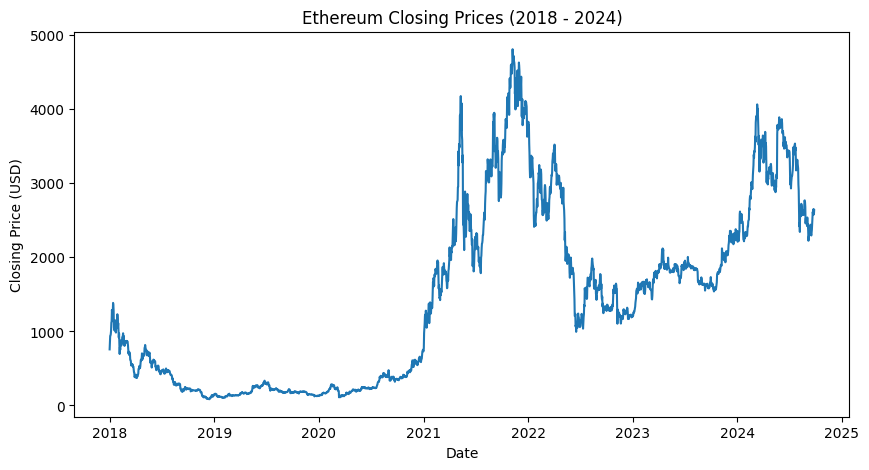

In [47]:
import matplotlib.pyplot as plt

# Plot the closing prices over time
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['Close'])
plt.title('Ethereum Closing Prices (2018 - 2024)')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.show()


## 2. Volume Over Time

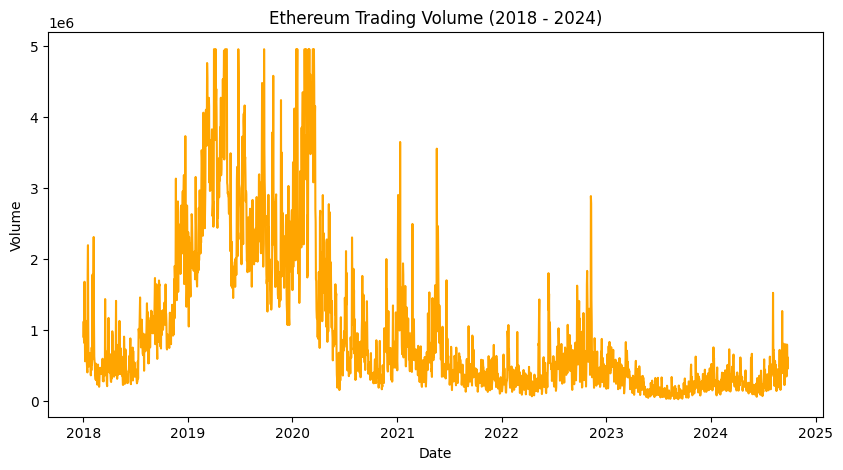

In [48]:
# Plot volume over time
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['Volume'], color='orange')
plt.title('Ethereum Trading Volume (2018 - 2024)')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()


## 3. Correlation Heatmap:

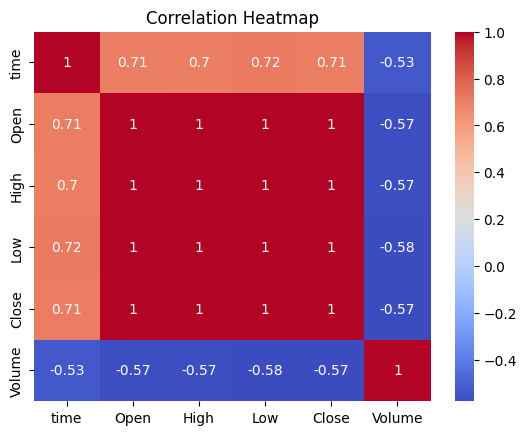

In [49]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# 8. Feature Engineering
Lag Features: Create lag features for the Close column to help the model learn from past prices.

In [50]:
# Creating lag features for the Close price
df['Close_lag1'] = df['Close'].shift(1)
df['Close_lag2'] = df['Close'].shift(2)
df['Close_lag3'] = df['Close'].shift(3)

# Drop rows with NaN values caused by shifting
df = df.dropna()


# 9. Model Building and Prediction


## 1. Split the Data into Train and Test Sets

In [51]:
from sklearn.model_selection import train_test_split

# Feature and target
X = df[['Open', 'High', 'Low', 'Volume', 'Close_lag1', 'Close_lag2', 'Close_lag3']]
y = df['Close']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


2. Train XGBoost Model


In [52]:
import xgboost as xgb

# Train the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.01)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [61]:
# Make predictions on the test set
predicted_prices = model.predict(X_test)
#y_pred

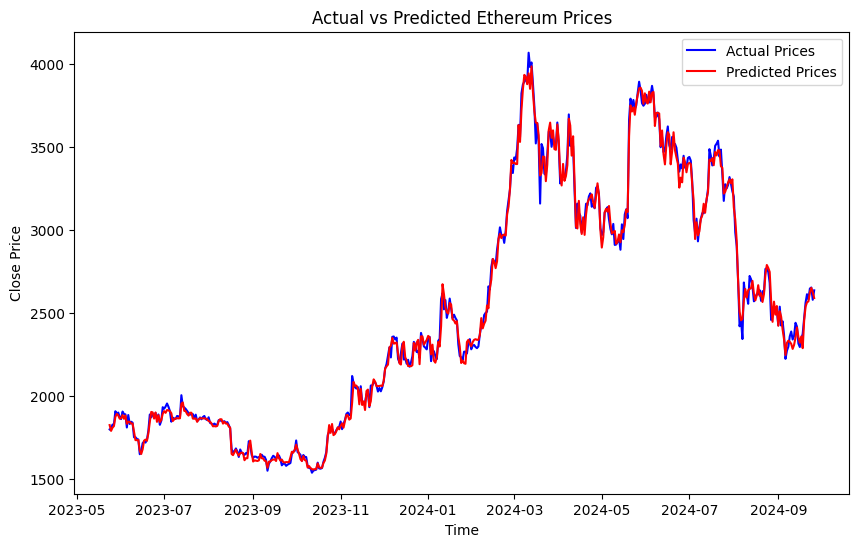

In [58]:
plt.figure(figsize=(10,6))
plt.plot(df['time'].iloc[len(X_train):], y_test, label='Actual Prices', color='blue')
plt.plot(df['time'].iloc[len(X_train):], y_pred, label='Predicted Prices', color='red')
plt.title('Actual vs Predicted Ethereum Prices')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()


# 10. Forecasting Future Prices
Forecasting for the Next 30 Days

In [56]:
import numpy as np
import pandas as pd
import xgboost as xgb

n_days = 30
forecasted_prices = []

# Start from the last row of the test set
last_row = X_test.iloc[-1].values.reshape(1, -1)

for i in range(n_days):
    #The model.predict method expects a numpy array or pandas DataFrame
    predicted_price = model.predict(last_row)  ##
    forecasted_prices.append(predicted_price[0])
    last_row = np.roll(last_row, shift=-1)
    last_row[0, -1] = predicted_price

# Forecast DataFrame
forecast_df = pd.DataFrame({
    'time': pd.date_range(start=df['time'].iloc[-1], periods=n_days+1, freq='D')[1:],
    'Forecasted_Close': forecasted_prices
})

<ipython-input-56-7597dc208484>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_row[0, -1] = predicted_price


# 11. Forecasting Visualization
1. Plot Actual vs Forecasted Prices

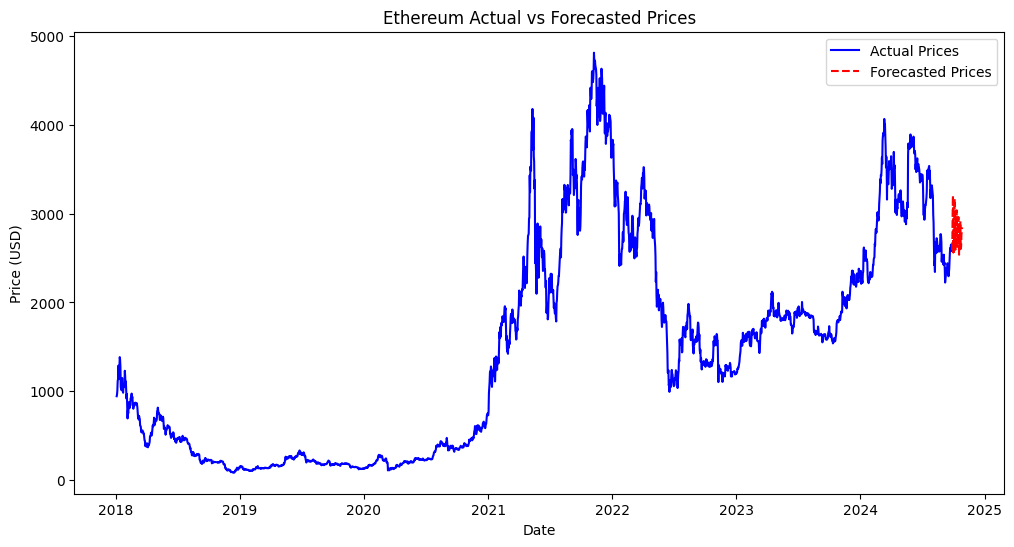

In [57]:
# Combine the actual and forecasted data
plot_df = pd.concat([df[['time', 'Close']], forecast_df], axis=0, ignore_index=True)

# Plot actual vs forecasted prices
plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['Close'], label='Actual Prices', color='blue')
plt.plot(forecast_df['time'], forecast_df['Forecasted_Close'], label='Forecasted Prices', color='red', linestyle='--')

plt.title('Ethereum Actual vs Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


<ipython-input-65-1efd8ff76486>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_row[0, -1] = predicted_price


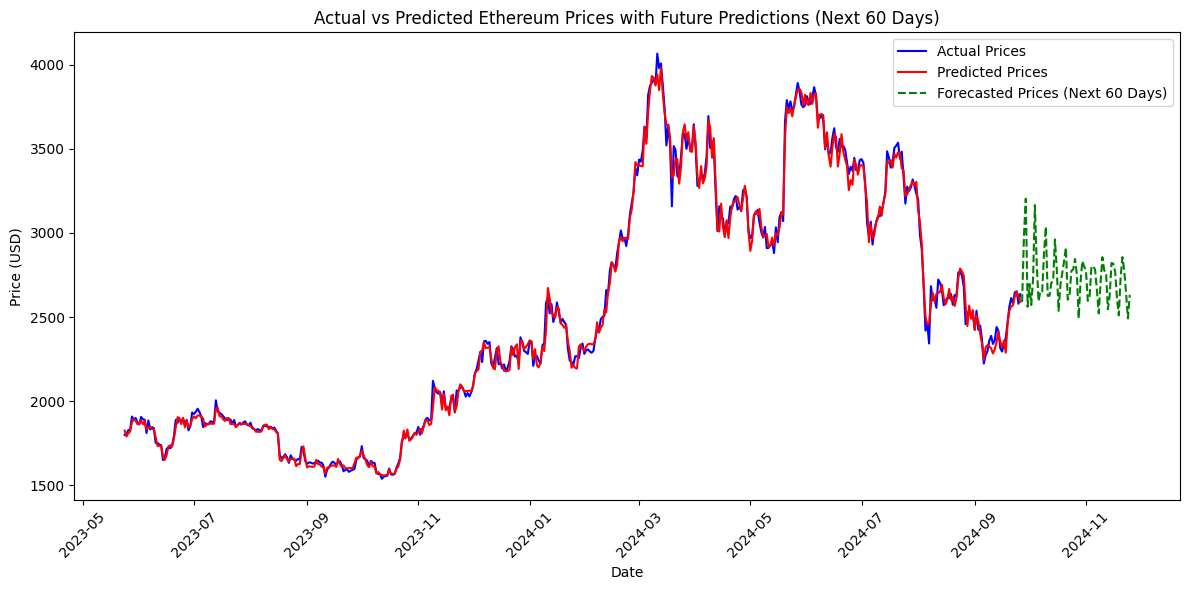

In [65]:
#n_days = 60 for forecasting
n_days = 60
forecasted_prices = []

# Start from the last row of the test set
last_row = X_test.iloc[-1].values.reshape(1, -1)

for i in range(n_days):
    predicted_price = model.predict(last_row)
    forecasted_prices.append(predicted_price[0])
    last_row = np.roll(last_row, shift=-1)
    last_row[0, -1] = predicted_price

# Forecast DataFrame for the next 60 days
forecast_df = pd.DataFrame({
    'time': pd.date_range(start=df['time'].iloc[-1], periods=n_days + 1, freq='D')[1:],
    'Forecasted_Close': forecasted_prices
})

# Combine actual and forecasted data for visualization
actual_df = pd.DataFrame({
    'time': df['time'].iloc[len(X_train):],
    'Actual_Close': y_test
})

predicted_df = pd.DataFrame({
    'time': df['time'].iloc[len(X_train):],
    'Predicted_Close': predicted_prices
})

# Merge dataframes for plotting
plot_df = actual_df.merge(predicted_df, on='time', how='outer').merge(forecast_df, on='time', how='outer')

# Visualization of actual, predicted, and forecasted prices
plt.figure(figsize=(12, 6))
plt.plot(plot_df['time'], plot_df['Actual_Close'], label='Actual Prices', color='blue')
plt.plot(plot_df['time'], plot_df['Predicted_Close'], label='Predicted Prices', color='red')
plt.plot(forecast_df['time'], forecast_df['Forecasted_Close'], label='Forecasted Prices (Next 60 Days)', color='green', linestyle='--')

plt.title('Actual vs Predicted Ethereum Prices with Future Predictions (Next 60 Days)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 12. Conclusion
In this project, successfully built a model to forecast Ethereum prices using XGBoost. After performing data cleaning, EDA, and feature engineering, the model was trained and tested on historical Ethereum prices. The forecast for future prices was visualized, providing insights into the potential movement of Ethereum prices in the coming days. The methodology and code can be adapted for other financial datasets to help with investment strategies and market predictions.